In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
import cv2
import math
import numpy as np
import glob
from collections import deque
from random import random, seed
from statistics import mean
import scipy
import time

In [2]:
training_data = np.load('data/training.npy', allow_pickle=True) # shape: [(frame, calibration), ...]
test_data = np.load('data/test.npy', allow_pickle=True) # shape: (frame,)

In [291]:
# (give them constants formatting to make it easier to read)
# GLOBAL VARIABLES
standard_left_lane = (-0.71, 840) # (slope, intercept)
standard_right_lane = (0.71, 0) # (slope, intercept)

min_lane_slope = 0.5
max_lane_slope = 1.5

line_adj_factor = 0.2

momentum = 0.95

Key assumption: "ideal" left line is slope -0.71 intersect left 840
Key assumption: "ideal" right line is slope 0.71 intersect left 0

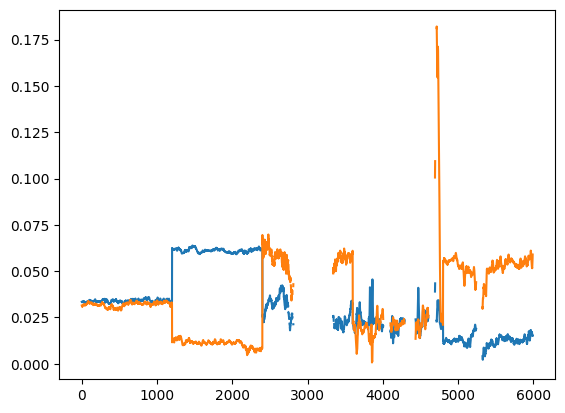

In [8]:
radians = training_data[:,1]
r1 = [r1 for r1, _ in radians]
r2 = [r2 for _, r2 in radians]
x = [i for i in range(len(radians))]

plt.plot(x, r1, label='pitch')
plt.plot(x, r2, label='yaw')

<AxesSubplot: >

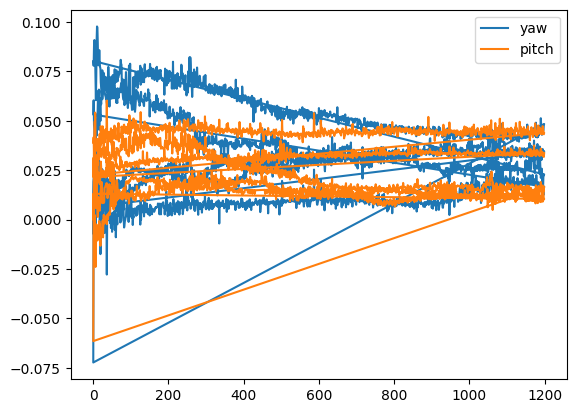

In [281]:
test_labels_0 = pd.read_csv('test/0.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
test_labels_1 = pd.read_csv('test/1.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
test_labels_2 = pd.read_csv('test/2.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
test_labels_3 = pd.read_csv('test/3.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
test_labels_4 = pd.read_csv('test/4.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
test_videos = [test_labels_0, test_labels_1, test_labels_2, test_labels_3, test_labels_4]

test_labels = pd.concat(test_videos)

ax = plt.gca()
test_labels.plot(kind='line',y='yaw',ax=ax)
test_labels.plot(kind='line',y='pitch',ax=ax)
# why do I have negative values?
# why is it unclear where one video starts and the other ends?

In [91]:
train_labels_0 = pd.read_csv('labeled/0.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
train_labels_1 = pd.read_csv('labeled/1.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
train_labels_2 = pd.read_csv('labeled/2.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
train_labels_3 = pd.read_csv('labeled/3.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
train_labels_4 = pd.read_csv('labeled/4.txt', names = ['pitch', 'yaw'], delim_whitespace=True)
train_frames = [train_labels_0, train_labels_1, train_labels_2, train_labels_3, train_labels_4]

train_labels = pd.concat(train_frames)
print(train_labels.shape)

(5996, 2)


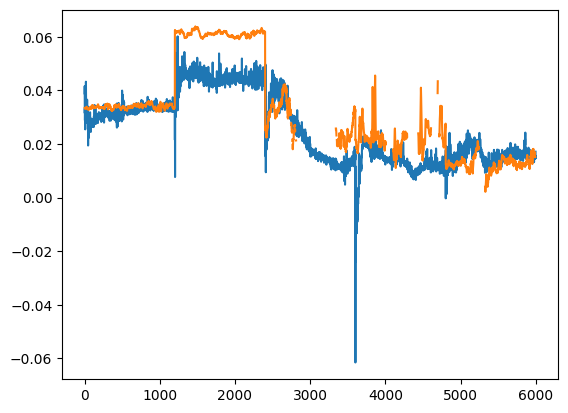

In [282]:
# pitch comparison
# ax = plt.gca()
# test_labels.plot(kind='line',y='pitch',ax=ax)
# train_labels.plot(kind='line',y='pitch',ax=ax)

train_pitch_labels = [x for x in train_labels['pitch']]
test_pitch_labels = [x for x in test_labels['pitch']]


plt.plot(range(1,5997), test_pitch_labels, label='pitch-test')
plt.plot(range(1,5997), train_pitch_labels, label='pitch-train')

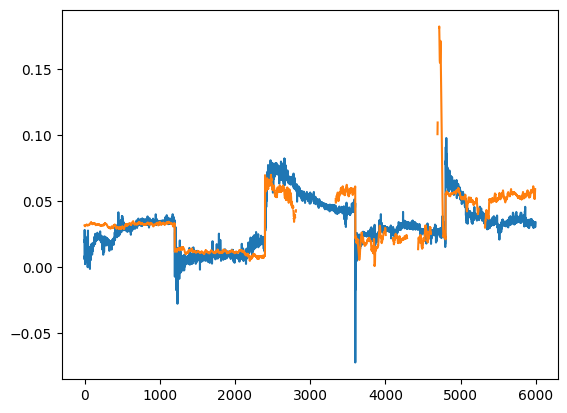

In [283]:
train_yaw_labels = [x for x in train_labels['yaw']]
test_yaw_labels = [x for x in test_labels['yaw']]


plt.plot(range(5996), test_yaw_labels, label='yaw-test')
plt.plot(range(5996), train_yaw_labels, label='yaw-train')

<AxesSubplot: >

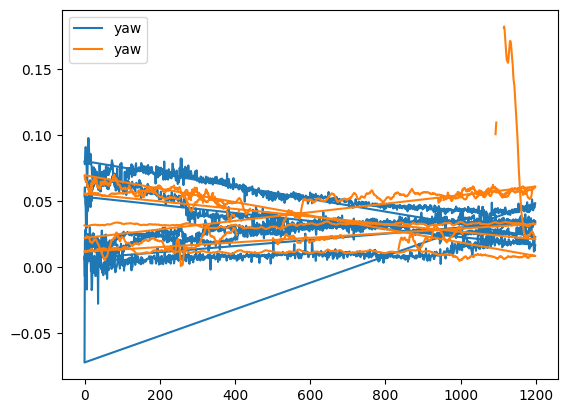

In [284]:
# yaw comparison
ax = plt.gca()
test_labels.plot(kind='line',y='yaw',ax=ax)
train_labels.plot(kind='line',y='yaw',ax=ax)

In [285]:
# CODE IN THIS BLOCK IS FROM https://github.com/commaai/openpilot/tree/master/common/transformations

# TESTING
focal_length = 910.0
frame_size = (1164, 874)

# aka 'K' aka camera_frame_from_view_frame
calib_challenge_intrinsics = np.array([
  [focal_length,  0.0,  float(frame_size[0])/2],
  [0.0,  focal_length,  float(frame_size[1])/2],
  [0.0,  0.0,                              1.0]])


def normalize(img_pts, intrinsics=calib_challenge_intrinsics):
  # normalizes image coordinates
  # accepts single pt or array of pts
  intrinsics_inv = np.linalg.inv(intrinsics)
  img_pts = np.array(img_pts)
  input_shape = img_pts.shape
  img_pts = np.atleast_2d(img_pts)
  img_pts = np.hstack((img_pts, np.ones((img_pts.shape[0], 1))))
  img_pts_normalized = img_pts.dot(intrinsics_inv.T)
  img_pts_normalized[(img_pts < 0).any(axis=1)] = np.nan
  return img_pts_normalized[:, :2].reshape(input_shape)


def get_calib_from_vp(vp):
  vp_norm = normalize(vp)
  yaw_calib = np.arctan(vp_norm[0])
  pitch_calib = -np.arctan(vp_norm[1]*np.cos(yaw_calib))
  roll_calib = 0
  return roll_calib, pitch_calib, yaw_calib


In [286]:
# Test to add for going from vp -> _roll, pitch, yaw: make the vp the center of the camera and see if 
# all angles are 0

# inserting a single point
test_vp = np.array([int(frame_size[0]/2), int(frame_size[1]/2)]) # center of the image, int not necessary when running
roll_calib, pitch_calib, yaw_calib = get_calib_from_vp(test_vp)
assert(roll_calib == 0.0 and pitch_calib == 0.0 and yaw_calib == 0.0), "Error with vp -> calibration step"

In [279]:
# Tested assumption that when vp = center of img, the pitch = yaw = 0.0 would yield 100% MSE according to eval.py (it does)

# vid[0] is the name of the file, vid[1] is the video data
vid_5 = ('test/0.txt', training_data[:1200])
vid_6= ('test/1.txt', training_data[1200:2400])
vid_7 = ('test/2.txt', training_data[2400:3600])
vid_8 = ('test/3.txt', training_data[3600:4800])
vid_9 = ('test/4.txt', training_data[4800:5996])
test_videos = [vid_5, vid_6, vid_7, vid_8, vid_9]

def generate_and_write_test_labels(vid):
  prev_left_lanes = []
  prev_right_lanes = []

  with open(vid[0], 'w') as f:
      for frame, _gt in vid[1]:
          vp = process_image(frame, prev_left_lanes, prev_right_lanes)
          _roll_calib, pitch_calib, yaw_calib = get_calib_from_vp(vp)
          f.write(f'{pitch_calib} {yaw_calib}\n')
      f.close()


In [280]:
# Carefuly run this block, it will overwrite the test labels
for test_video in test_videos:
    generate_and_write_test_labels(test_video)

In [289]:
# going low on thresholding and relying on my later filters to get rid of noise, will tinker with this later
def get_canny_edge_detected_img(img, low_threshold=0, high_threshold=50): 
    return cv2.Canny(img, low_threshold, high_threshold)

def get_roi_from_img(img):
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    y, x = img.shape
    y_offset = -10
    x_offset = 300
    roi_vertices = np.array([[(50, y - 150),
                              (x / 2 - x_offset, y / 1.8 + y_offset),
                              (x / 2 + x_offset, y / 1.8 + y_offset),
                              (x - 50, y - 150)]],
                              dtype=np.int32)
    # roi_vertices_2 = np.array([[(50, y - 200),
    #                           (x / 2 - x_offset, y / 1.8 + y_offset - 50),
    #                           (x / 2 + x_offset, y / 1.8 + y_offset - 50),
    #                           (x - 50, y - 200)]],
    #                           dtype=np.int32)
    cv2.fillPoly(mask, roi_vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(img, img, mask=mask)
    return masked_edges
    
def get_hough_lines_p(img, rho=2, theta=31*np.pi/180, threshold=10, min_line_length=5, max_line_gap=20):
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

def show(imgs, cmap=None):
    rows = (len(imgs)+1)//2
    plt.figure(figsize=(10, 11))
    for i, img in enumerate(imgs):
        plt.subplot(rows, 2, i+1)
        cmap = 'gray' if len(img.shape)==2 else cmap
        plt.imshow(img, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=8)
    plt.show()
    
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return ((x1, y1), (x2, y2))

def filter_lines(copy_original_img, hough_lines):
    left_filtered_lines = []
    right_filtered_lines = []
    for line in hough_lines:
        x1, y1, x2, y2 = line.reshape(4)
        slope = (y2-y1)/((x2-x1) + 0.0000001) # avoid division by zero
        intercept = y1 - (slope * x1)

        left_intercept_prop = intercept > 800 and intercept < 1300
        right_intercept_prop = intercept > -50 and intercept < 300
        
        left_slope_prop = slope < -min_lane_slope and slope > -max_lane_slope
        right_slope_prop = slope > min_lane_slope and slope < max_lane_slope
        
        if left_slope_prop and left_slope_prop:
            left_filtered_lines.append(line)
        elif right_slope_prop and right_intercept_prop:
            right_filtered_lines.append(line)
    return left_filtered_lines, right_filtered_lines

def lines_to_points(lines):
    pts = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            pt1, pt2 = (x1, y1), (x2, y2)
            pts.append(pt1)
            pts.append(pt2)
    return pts


def left_lane_min_max_y(x, y):
    min_y = -x + 864
    max_y = -x + 1196
    return min_y <= y <= max_y 
    
    # min_slope, min_diff = 173/180, 865/3
    # max_slope, max_diff = -27/25, 0

def right_lane_min_max_y(x, y):
    min_y = x - 300
    max_y = x
    return min_y <= x <= max_y

# right_lane = [1200, 865, 300, 0] # [x1, y1, x2, y2]
# right_lane2 = [900, 865, 0, 0]
# left_lane = [0, 864, 800, 0]
# left_lane2 = [300, 864, 1100, 0]
def filter_points(pts, lane, img):
    new_pts = []
    for x, y in pts:
        func = left_lane_min_max_y if lane == 'left' else right_lane_min_max_y
        if func(x, y):
            new_pts.append((x, y))
            cv2.circle(img, (x, y), 5, (0, 0, 255), -1)
    return new_pts, img
        

def get_pts_close_to_adj_line(pts, slope, intercept, img):
    new_pts = []
    for x, y in pts:
        if abs(y - (slope*x + intercept)) < 100:
            new_pts.append((x, y))
            cv2.circle(img, (x, y), 5, (0, 0, 255), -1)
    return new_pts, img

def points_to_lane(img, pts):
    if len(pts):
        x = [pt[0] for pt in pts]
        y = [pt[1] for pt in pts]
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
        
        # filter points a second time
        pts_close_to_line, new_img = get_pts_close_to_adj_line(pts, slope, intercept, img)
        x = [pt[0] for pt in pts_close_to_line]
        y = [pt[1] for pt in pts_close_to_line]
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
        
        start_point = (int((img.shape[0] - intercept)/slope), img.shape[0])
        end_point = (int((0 - intercept)/slope), 0)
        cv2.line(img, start_point, end_point, (0, 255, 0), 10)
        
        left_slope_prop = slope < -min_lane_slope and slope > -max_lane_slope
        right_slope_prop = slope > min_lane_slope and slope < max_lane_slope
        if left_slope_prop or right_slope_prop:
            img, None, None
        return img, (slope, intercept), new_img
    return img, None, None

def get_intersection(line1, line2):
    if line1 is None or line2 is None:
        return None
    m1, b1 = line1
    m2, b2 = line2
    xi = (b1-b2) / (m2-m1)
    yi = m1 * xi + b1
    return np.array([abs(xi), abs(yi)])

def combine_with_previous_second_canny(canny, prev_canny_imgs):
    prev_canny_imgs.append(canny)
    if len(prev_canny_imgs) < 10: return canny
    return cv2.bitwise_or(canny, prev_canny_imgs[-10])
    


In [87]:

def lines_to_filtered_pts(image, hough_lines):
    left_filtered_lines, right_filtered_lines = filter_lines(image, hough_lines)
    
    left_pts = lines_to_points(left_filtered_lines)
    right_pts = lines_to_points(right_filtered_lines)
    
    left_filtered_pts, left_pts_img  = filter_points(left_pts, 'left', np.copy(image))
    right_filtered_pts, right_pts_image = filter_points(right_pts, 'right', np.copy(image))
    
    return left_filtered_pts, right_filtered_pts, left_pts_img, right_pts_image
    

In [88]:
# replacing points_to_lane
def matches_left_lane_props(slope):
    return slope < -min_lane_slope and slope > -max_lane_slope

def adjust_left_lane_line_props(slope, intercept):
    slope_adj = abs(slope) + line_adj_factor
    intercept = intercept +  line_adj_factor
    if slope < -max_lane_slope: 
        return slope + line_adj_factor, 
    return slope - slope_adj, intercept + line_adj_factor

def add_line_to_image(image, line):
    if line is None:
        return image
    slope, intercept = line
    start_point = (int((image.shape[0] - intercept)/slope), image.shape[0])
    end_point = (int((0 - intercept)/slope), 0)
    cv2.line(image, start_point, end_point, (0, 255, 0), 10)
    return image

def recursive_adjust_left_lane(left_pts, slope_history, img): 
    if len(slope_history) > 4 or len(left_pts) < 2: 
        return None, None
    x = [pt[0] for pt in left_pts]
    y = [pt[1] for pt in left_pts]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
    slope_history.append(slope)
    
    add_line_to_image(img, (slope, intercept))
    if matches_left_lane_props(slope): 
        return (slope, intercept), left_pts
    
    print('before adj slope: ', slope, 'matches left slope', matches_left_lane_props(slope))
    slope, intercept = adjust_left_lane_line_props(slope, intercept)
    print('adjust_left_lane_line_props: ', slope, intercept)
    print('\n')
    
    # filter points after adjusting the slope time, then retry finding a best fit line
    pts_close_to_adj_line = get_pts_close_to_adj_line(left_pts, slope, intercept)
    return recursive_adjust_left_lane(pts_close_to_adj_line, slope_history, img)

def left_pts_to_lane(left_pts, img):
    if len(left_pts) == 0: 
        return None
    slope_history = []
    left_lane, new_left_pts = recursive_adjust_left_lane(left_pts, slope_history, img)
    # print('length of slope history: ', len(slope_history), 'left_lane', left_lane)
    # show([img])
    # All of the below is just for visualization
    # copy_img = np.copy(img)
    # add_line_to_image(copy_img, left_lane)
    # for x, y in new_left_pts:
    #     cv2.circle(copy_img, (x, y), 5, (0, 0, 255), -1)
    
    return left_lane

In [89]:
# RIGHT LANE DETERMINATION FROM POINTS

def matches_right_lane_props(slope):
    return slope > min_lane_slope and slope < max_lane_slope

def adjust_right_lane_slope(slope):
    slope_adj = abs(slope) + slope_adj_factor
    if slope > max_lane_slope: 
        return slope - slope_adj
    else: 
        return slope + slope_adj

def recursive_adjust_right_lane(right_pts, slope_history): 
    if len(slope_history) > 4 or len(right_pts) < 2:
        return None, None
    x = [pt[0] for pt in right_pts]
    y = [pt[1] for pt in right_pts]
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
    slope_history.append(slope)
    
    if matches_right_lane_props(slope): return (slope, intercept), right_pts
    slope = adjust_right_lane_slope(slope)
    # filter points after adjusting the slope time, then retry finding a best fit line
    pts_close_to_adj_line = get_pts_close_to_adj_line(right_pts, slope, intercept)
    return recursive_adjust_right_lane(pts_close_to_adj_line, slope_history)

def right_pts_to_lane(right_pts, img):
    if len(right_pts) == 0: return None
    slope_history = []
    right_lane, new_right_pts = recursive_adjust_right_lane(right_pts, slope_history)
    
    
    # All of the below is just for visualization
    if right_lane is not None:
        slope, intercept = right_lane
        copy_img = np.copy(img)
        start_point = (int(np.copy(copy_img.shape[0] - intercept)/slope), copy_img.shape[0])
        end_point = (int((0 - intercept)/slope), 0)
        cv2.line(copy_img, start_point, end_point, (0, 255, 0), 10)
        for x, y in new_right_pts:
            cv2.circle(copy_img, (x, y), 5, (0, 0, 255), -1)
        show([copy_img])
    
    return left_lane

In [287]:
def pts_to_lane(pts, side, img):
    if len(pts) < 3: 
        return None
    
    slope, intercept = standard_left_lane if side == 'left' else standard_right_lane
    pts_close_to_line, new_img = get_pts_close_to_adj_line(pts, slope, intercept, img)
    
    x = [pt[0] for pt in pts_close_to_line]
    y = [pt[1] for pt in pts_close_to_line]
    if len(pts_close_to_line) < 3:
        return None
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x,y)
    
    has_lane_props = matches_left_lane_props(slope) if side == 'left' else matches_right_lane_props(slope)
    if has_lane_props:
        # print('slope: ', slope, 'matches left lane props', matches_left_lane_props(slope))
        start_point = (int((img.shape[0] - intercept)/slope), img.shape[0])
        end_point = (int((0 - intercept)/slope), 0)
        # cv2.line(new_img, start_point, end_point, (0, 255, 0), 10)
        return (slope, intercept)
    return None

In [68]:
def draw_ans_for_debug(img, left_lane, right_lane):
    copy_img = np.copy(img)
    if left_lane is not None:
        slope, intercept = left_lane
        start_point = (int((copy_img.shape[0] - intercept)/slope), copy_img.shape[0])
        end_point = (int((0 - intercept)/slope), 0)
        cv2.line(copy_img, start_point, end_point, (0, 255, 0), 10)
    else:
        slope, intercept = standard_left_lane
        start_point = (int((copy_img.shape[0] - intercept)/slope), copy_img.shape[0])
        end_point = (int((0 - intercept)/slope), 0)
        cv2.line(copy_img, start_point, end_point, (255, 0, 0), 10)
    if right_lane is not None:
        slope, intercept = right_lane
        start_point = (int((copy_img.shape[0] - intercept)/slope), copy_img.shape[0])
        end_point = (int((0 - intercept)/slope), 0)
        cv2.line(copy_img, start_point, end_point, (0, 255, 0), 10)
    else:
        slope, intercept = standard_right_lane
        start_point = (int((copy_img.shape[0] - intercept)/slope), copy_img.shape[0])
        end_point = (int((0 - intercept)/slope), 0)
        cv2.line(copy_img, start_point, end_point, (255, 0, 0), 10)
    show([copy_img])

In [69]:
def get_intersection_with_standard_lanes(left_lane, right_lane):
    left_line = left_lane if left_lane is not None else standard_left_lane
    right_line = right_lane if right_lane is not None else standard_right_lane
    return get_intersection(left_line, right_line)
    

In [256]:
def lane_with_mom_calc(lane, prev_lanes, standard_lane):
    lane = lane if lane is not None else standard_lane
    prev_lanes.append(lane)
    
    scaling_factor = len(prev_lanes)/(len(prev_lanes) + 5)
    scaled_momentum = momentum * scaling_factor
    prev_lane_avg = np.mean(np.array(prev_lanes), axis=0)
    slope_with_scaled_momentum = prev_lane_avg[0] * scaled_momentum + lane[0] * (1 - scaled_momentum)
    intercept_with_scaled_momentum = prev_lane_avg[1] * scaled_momentum + lane[1] * (1 - scaled_momentum)
    # print('slope percent adjustment: ', abs(lane[0] - slope_with_scaled_momentum) / lane[0])
    # print('slope percent adjustment: ', abs(lane[1] - intercept_with_scaled_momentum) / lane[1])
    return slope_with_scaled_momentum, intercept_with_scaled_momentum

In [278]:
def process_image(image, prev_left_lanes, prev_right_lanes):
    copy_img = np.copy(image)
    gray_img = cv2.cvtColor(copy_img, cv2.COLOR_BGR2GRAY)
    canny = cv2.Canny(copy_img, 50, 100)
    masked_edges = get_roi_from_img(canny)
    hough_lines = get_hough_lines_p(masked_edges)
    
    # take the hough lines, give me a set of acceptable points
    left_pts, right_pts, left_pts_img, right_pts_image = lines_to_filtered_pts(copy_img, hough_lines)

    # take the acceptable points, remove the ones super far away from a "standard lane" and return a best fit line
    test_img = np.copy(image)
    left_lane = pts_to_lane(left_pts, 'left', test_img)
    right_lane = pts_to_lane(right_pts, 'right', test_img)

    # append the calc'ed lanes to the prev lanes if they exist and calc the momentum
    left_lane_with_mom = lane_with_mom_calc(left_lane, prev_left_lanes, standard_left_lane)
    right_lane_with_mom = lane_with_mom_calc(right_lane, prev_right_lanes, standard_right_lane)
    
    # draw_ans_for_debug(np.copy(image), left_lane, right_lane)
    vp = get_intersection_with_standard_lanes(left_lane_with_mom, right_lane_with_mom)
    
    return vp


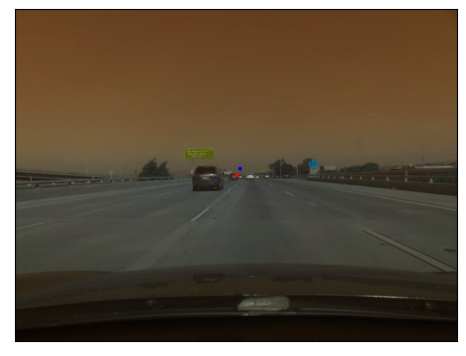

In [400]:
# Potentially edit standard lines? They are pretty close to perfect mounting

intersection = get_intersection(standard_left_lane, standard_right_line)
im_copy = np.copy(test_data[100])
cv2.circle(im_copy, (int(intersection[0]), int(intersection[1])), 5, (0, 0, 255), -1)
cv2.circle(im_copy, (int(test_vp[0]), int(test_vp[1])), 5, (255, 0, 0), -1)
cv2.line
show([im_copy])

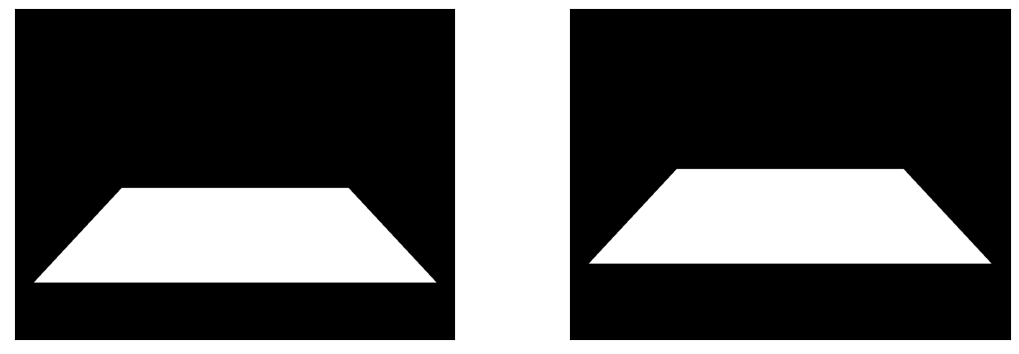

(None, None)

In [269]:
frame = test_data[0]
current_img = np.copy(frame)
process_image(current_img, left_lanes, right_lanes)

/var/folders/ww/qt0f4brd6dq8hp1wkttfj8fr0000gn/T/ipykernel_63760/3012996119.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_yaw_labels = [x for x in train_labels['yaw'][:count]]
/var/folders/ww/qt0f4brd6dq8hp1wkttfj8fr0000gn/T/ipykernel_63760/3012996119.py:19: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_pitch_labels = [x for x in train_labels['pitch'][:count]]


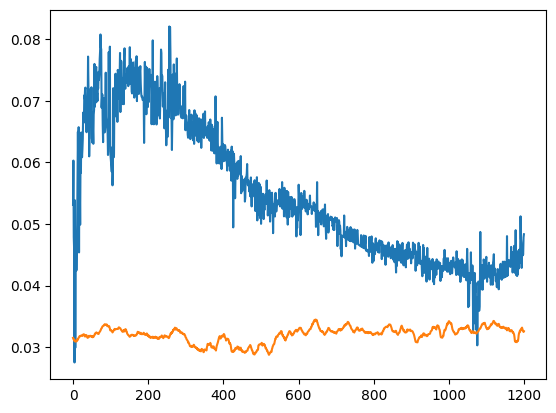

In [248]:
# rand_idx = num = math.floor(random() * test_data.shape[0]) 
calculated_vps = []
left_lanes = []
right_lanes = []
scale = []

count = 1200
start_idx = 2400
training_slice = training_data[start_idx:count+start_idx]
for frame, _gt in training_slice:
    current_img = np.copy(frame)
    vp = process_image(current_img, left_lanes, right_lanes)
    _roll_calib, pitch_calib, yaw_calib = get_calib_from_vp(vp)
    calculated_vps.append([pitch_calib, yaw_calib])

train_yaw_labels = [x for x in train_labels['yaw'][:count]]
test_yaw_labels = [yaw for pitch, yaw in calculated_vps]

train_pitch_labels = [x for x in train_labels['pitch'][:count]]
test_pitch_labels = [pitch for pitch, yaw in calculated_vps]


# plt.plot(range(count), scale, label='scaling factor')
plt.plot(range(count), test_yaw_labels, label='yaw-test')
plt.plot(range(count), train_yaw_labels, label='yaw-train')
# plt.plot(range(count), test_pitch_labels, label='pitch-test')
# plt.plot(range(count), train_pitch_labels, label='pitch-train')